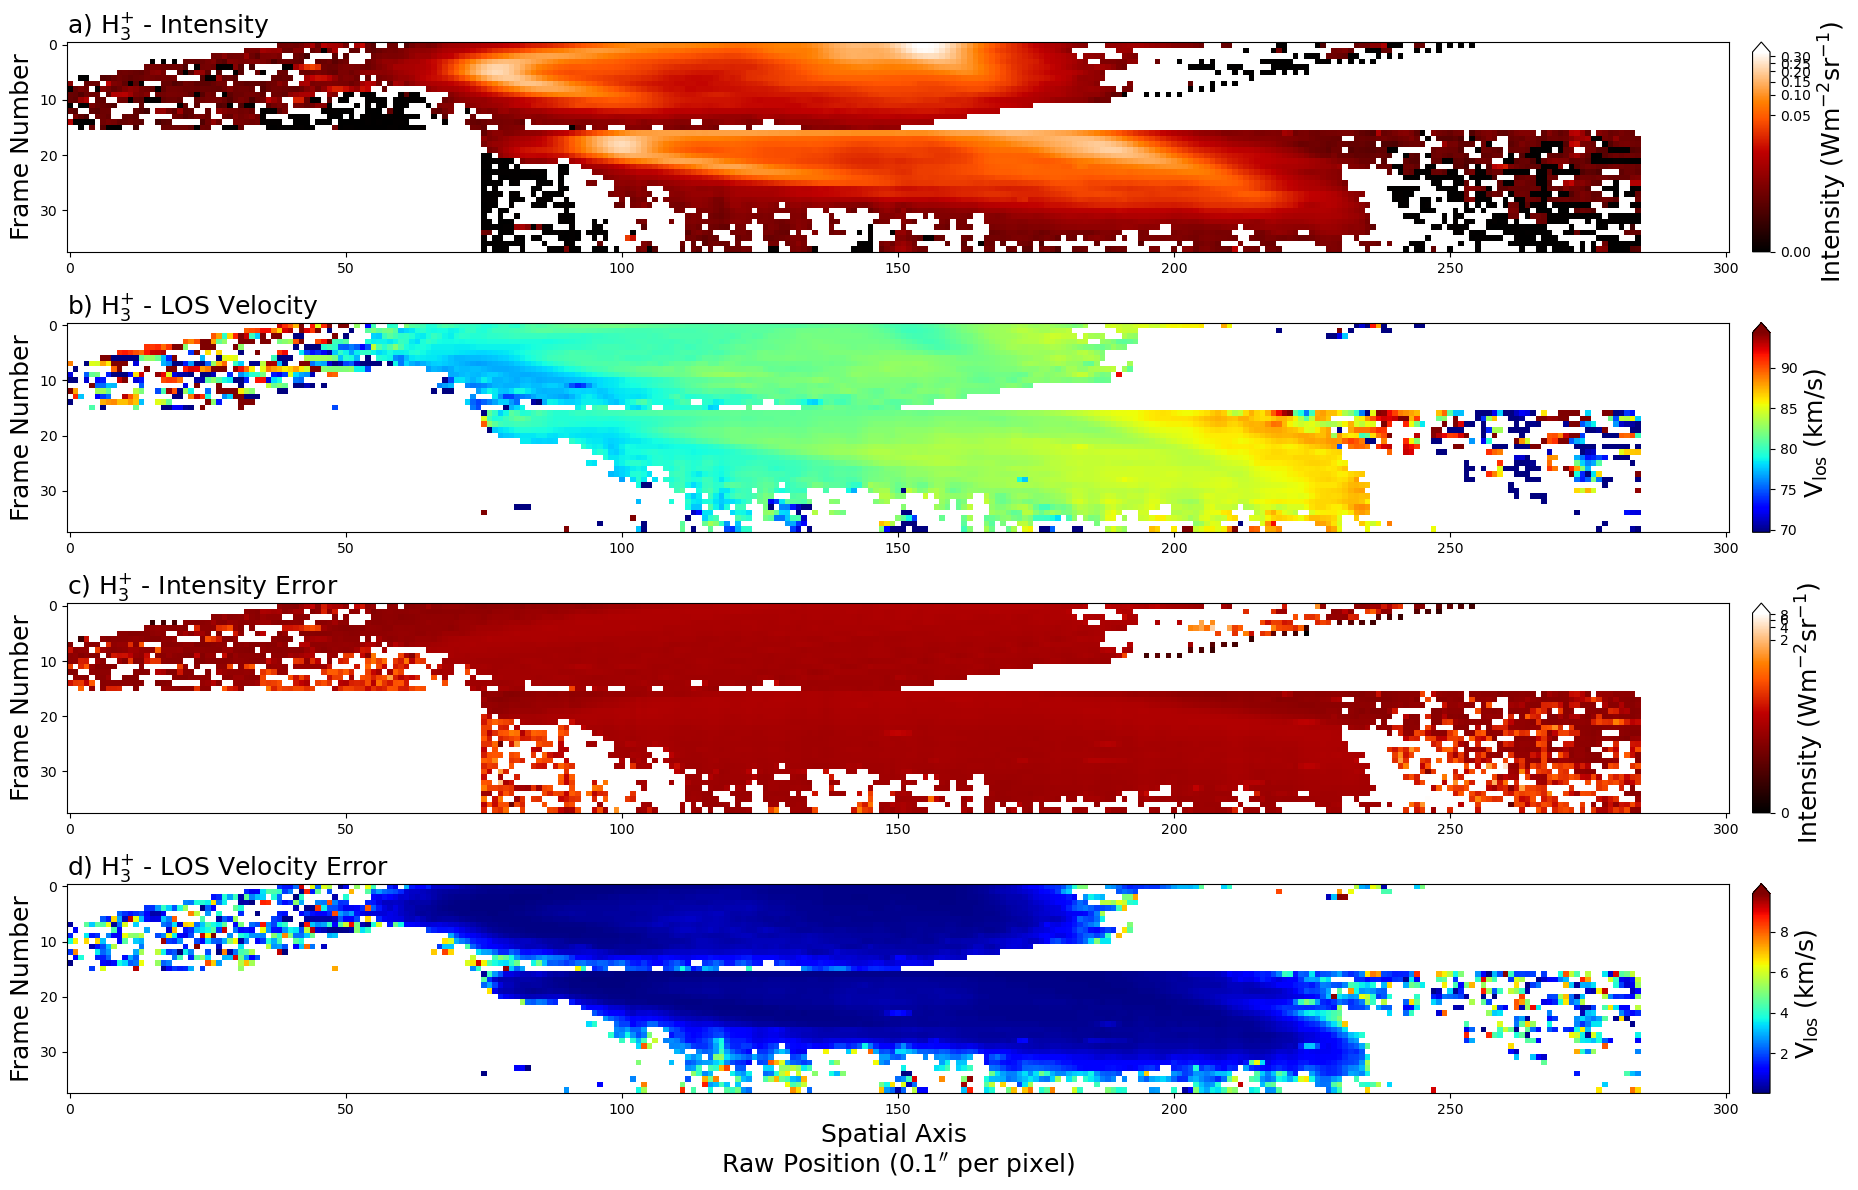

In [1]:
# import packages
from astropy.io import fits
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from lmfit import Model, fit_report
from lmfit.models import LinearModel


h3p_int_shifted = fits.open('h3p_int_shifted.fits', ignore_missing_end=True)[0].data
h3p_los_shifted = fits.open('h3p_los_shifted.fits', ignore_missing_end=True)[0].data
h3p_int_shifted_error = fits.open('h3p_int_shifted_error.fits', ignore_missing_end=True)[0].data
h3p_los_shifted_error = fits.open('h3p_los_shifted_error.fits', ignore_missing_end=True)[0].data

fig = plt.figure(figsize=(24,12), tight_layout=True)

fig.add_subplot(411)
plt.imshow(h3p_int_shifted, cmap='gist_heat', norm=colors.PowerNorm(gamma=0.2))
# plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
plt.ylabel('Frame Number', fontsize=18)
plt.title('a) H$_3^{+}$ - Intensity', loc='left', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='Intensity (Wm$^{-2}$sr$^{-1}$)',size=18)

fig.add_subplot(412)
plt.imshow(h3p_los_shifted, cmap='jet')
# plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
plt.ylabel('Frame Number', fontsize=18)
plt.title('b) H$_3^{+}$ - LOS Velocity', loc='left', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='V$_{\mathrm{los}}$ (km/s)',size=18)

fig.add_subplot(413)
# colMap = cm.gist_heat
# colMap.set_bad(color='white')
plt.imshow(h3p_int_shifted_error, cmap='gist_heat', norm=colors.PowerNorm(gamma=0.1))
# plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
plt.ylabel('Frame Number', fontsize=18)
plt.title('c) H$_3^{+}$ - Intensity Error', loc='left', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='Intensity (Wm$^{-2}$sr$^{-1}$)',size=18)

fig.add_subplot(414)
plt.imshow(h3p_los_shifted_error, cmap='jet')
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
plt.ylabel('Frame Number', fontsize=18)
plt.title('d) H$_3^{+}$ - LOS Velocity Error', loc='left', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='V$_{\mathrm{los}}$ (km/s)',size=18)

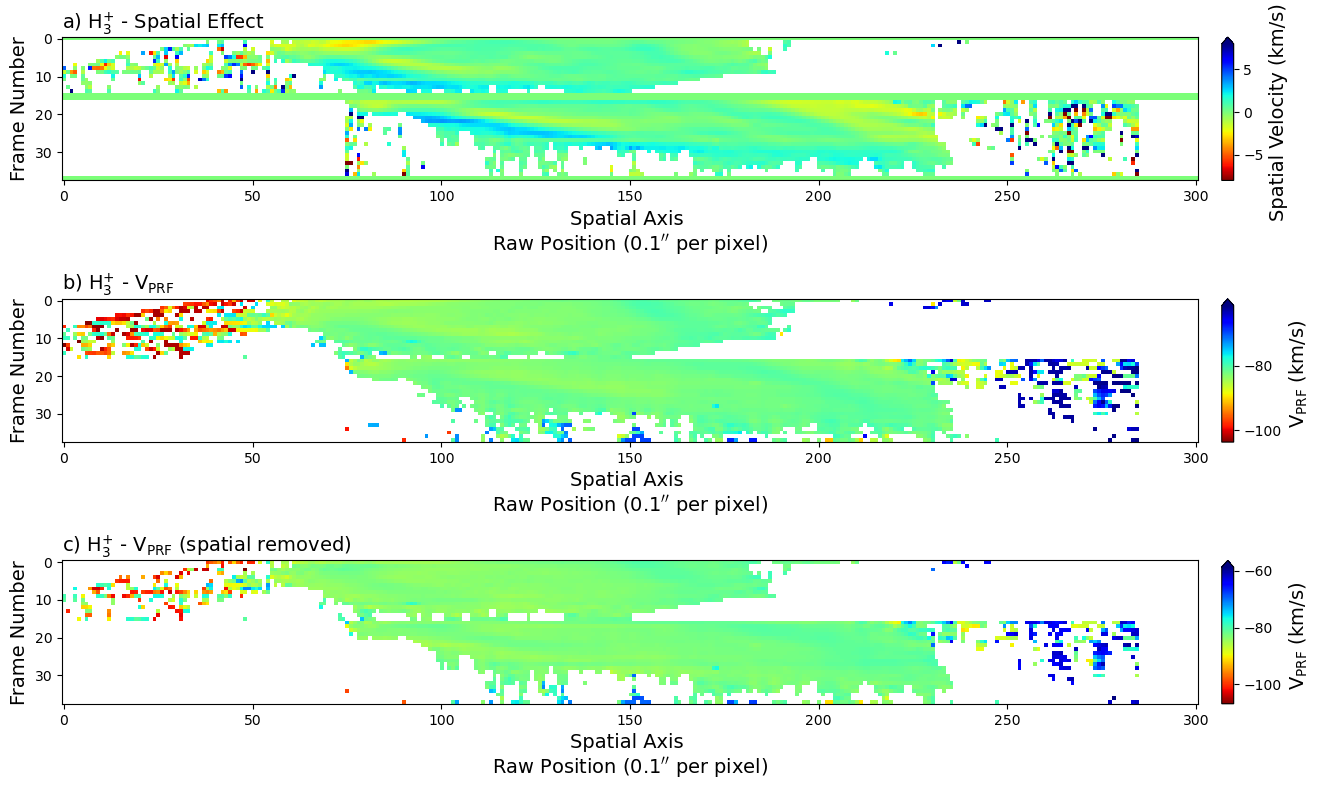

In [4]:
ang_diam = 40.58867 # arcseconds
# ang_diam/(0.1) slit unit = 0.1 arcsec/pixel
limb_vel = 12.572 # V_equator of Jupiter in km/s

# vel_slope = limb_vel / (ang_diam/(0.1)/2)
vel_slope = limb_vel * 2 / (ang_diam / (0.1))

x = np.linspace(-150,150,301)
rot_rate = vel_slope * x
# rot_rate = rot_rate - rot_rate[150]

h3p_plan_vel = h3p_los_shifted + 0

for i in range(np.size(h3p_los_shifted, 0)):
    h3p_plan_vel[i,:] = h3p_los_shifted[i,:] - rot_rate


spatial_velocity = h3p_int_shifted + 0
spatial_velocity[::] = 0

for i in range(np.size(spatial_velocity, 1)):
    for j in range(1, np.size(spatial_velocity, 0)-1):
        if j not in (15,16):
            y = np.arange(3)
            p = np.array((h3p_int_shifted[j-1][i], h3p_int_shifted[j][i], h3p_int_shifted[j+1][i]))
#             print(j,i)
    #         plt.figure()
    #         plt.plot(y, p, 'k.', label='original')
            f = sp.interpolate.interp1d(y,p)
            xnew = np.linspace(0,2,7)
    #         plt.figure()
    #         plt.plot(xnew, f(xnew), 'r.', label='interpolate')
    #         plt.legend()
    #         print(f(xnew[2]), f(xnew[4]))
            p1 = f(xnew[2])
            p3 = f(xnew[4])
            di = (p3 - p1)/(p3 + p1)
            dv = 7.99*di

            if np.isreal(dv):
                spatial_velocity[j,i] = dv

# h2_spat_vel2 = fits.open('h2_spatial_vel2.fits', ignore_missing_end=True)[0].data
# h2_plan_vel2 = fits.open('h2_plan_vel2.fits', ignore_missing_end=True)[0].data

# spatial_velocity2 = spatial_velocity + 0
# spatial_velocity2[np.isnan(h2_spat_vel2)] = np.nan
# spatial_velocity2[spatial_velocity <= 1.5] = np.nan

# h3p_plan_vel2 = h3p_plan_vel + 0
# h3p_plan_vel2[h3p_plan_vel2 > 5] = np.nan
# h3p_plan_vel2[h3p_plan_vel2 < -1] = np.nan
# h3p_plan_vel2[h3p_los_shifted_error > 1] = np.nan
# h3p_plan_vel2[np.isnan(h2_plan_vel2)] = np.nan

# spatial_velocity2[np.isnan(h3p_plan_vel2)] = np.nan

h3p_corrected_vel = h3p_plan_vel-spatial_velocity
# h3p_corrected_vel[h3p_corrected_vel > 85] = 85
# h3p_corrected_vel[h3p_corrected_vel < 80] = 80

# h3p_plan_vel[h3p_plan_vel > 3] = 3
# h3p_plan_vel[h3p_plan_vel < -3] = -3


fig = plt.figure(figsize=(24,8), tight_layout=True)

fig.add_subplot(311)
plt.imshow(spatial_velocity*(-1), cmap='jet_r')
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=14)
plt.ylabel('Frame Number', fontsize=14)
plt.title('a) H$_3^{+}$ - Spatial Effect', loc='left', fontsize=14)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='Spatial Velocity (km/s)',size=14)

fig.add_subplot(312)
plt.imshow(h3p_plan_vel*(-1), cmap='jet_r')
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=14)
plt.ylabel('Frame Number', fontsize=14)
plt.title('b) H$_3^{+}$ - V$_{\mathrm{PRF}}$', loc='left', fontsize=14)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='V$_{\mathrm{PRF}}$ (km/s)',size=14)

fig.add_subplot(313)
plt.imshow(h3p_corrected_vel*(-1), cmap='jet_r')
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=14)
plt.ylabel('Frame Number', fontsize=14)
plt.title('c) H$_3^{+}$ - V$_{\mathrm{PRF}}$ (spatial removed)', loc='left', fontsize=14)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='V$_{\mathrm{PRF}}$ (km/s)',size=14)

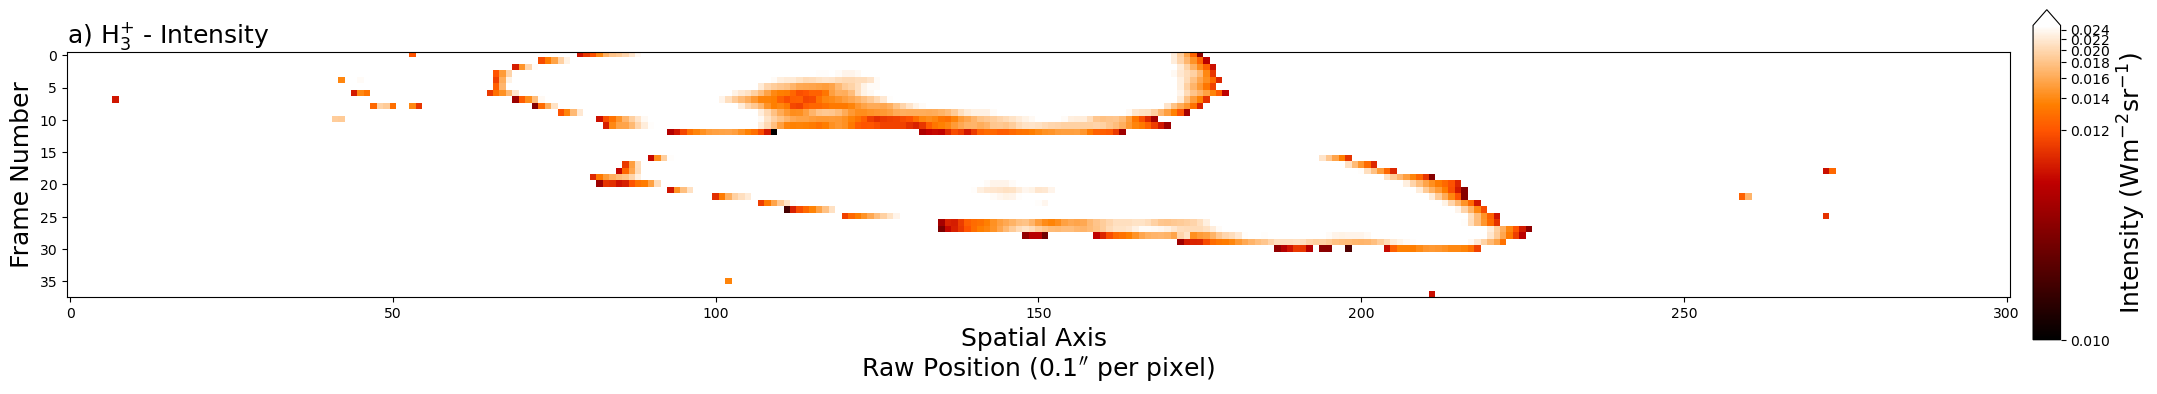

In [17]:
h3p_bright2 = h3p_int_shifted + 0
h3p_bright2[h3p_int_shifted > 0.025] = np.nan
h3p_bright2[h3p_int_shifted < 0.01] = np.nan
# h3p_bright2[16:,:78] = np.nan
# h3p_bright2[16:,245:] = np.nan

fig = plt.figure(figsize=(24,4), tight_layout=True)

fig.add_subplot(111)
plt.imshow(h3p_bright2, cmap='gist_heat', norm=colors.PowerNorm(gamma=0.2))
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
plt.ylabel('Frame Number', fontsize=18)
plt.title('a) H$_3^{+}$ - Intensity', loc='left', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='Intensity (Wm$^{-2}$sr$^{-1}$)',size=18)

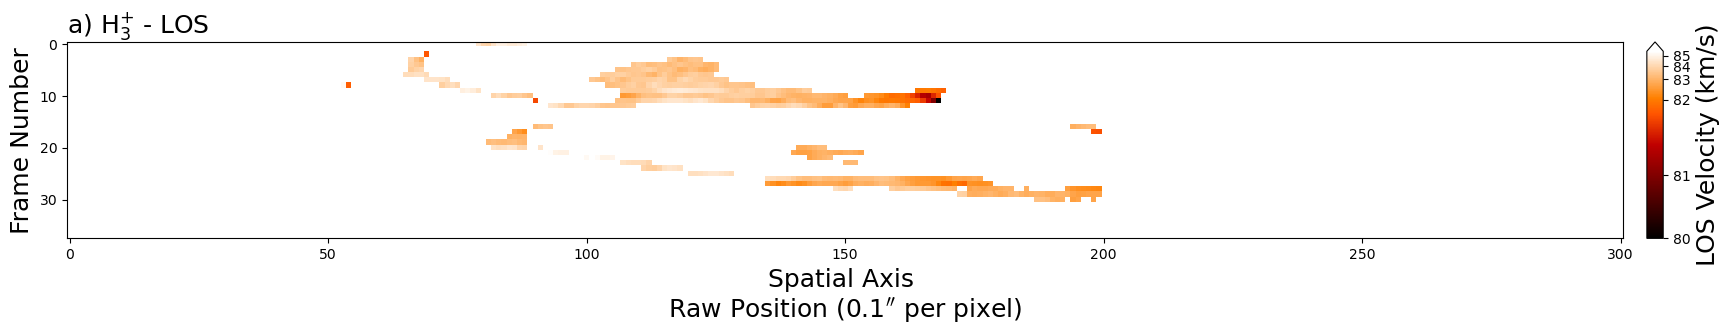

In [18]:
los_vel4 = h3p_corrected_vel + 0
# los_vel4[:16] = np.nan
los_vel4[:][np.isnan(h3p_bright2[:])] = np.nan
los_vel4[los_vel4 < 80] = np.nan
los_vel4[los_vel4 > 87] = np.nan
los_vel4[:,:50] = np.nan
los_vel4[:,200:] = np.nan
los_vel4[:16,170:] = np.nan
los_vel4[:16,70:90][los_vel4[:16,70:90] < 83] = np.nan
# los_vel4[:,:175][los_vel4[:,:175] < 82.5] = np.nan
# los_vel4[:,:120][los_vel4[:,:120] < 82.5] = np.nan
# los_vel4[:,120:180][los_vel4[:,120:180] < 82] = np.nan
# los_vel4[:,120:180][los_vel4[:,120:180] > 85] = np.nan

fig = plt.figure(figsize=(24,8), tight_layout=True)

fig.add_subplot(313)
plt.imshow(los_vel4, cmap='gist_heat', norm=colors.PowerNorm(gamma=0.2))
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
plt.ylabel('Frame Number', fontsize=18)
plt.title('a) H$_3^{+}$ - LOS', loc='left', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='LOS Velocity (km/s)',size=18)

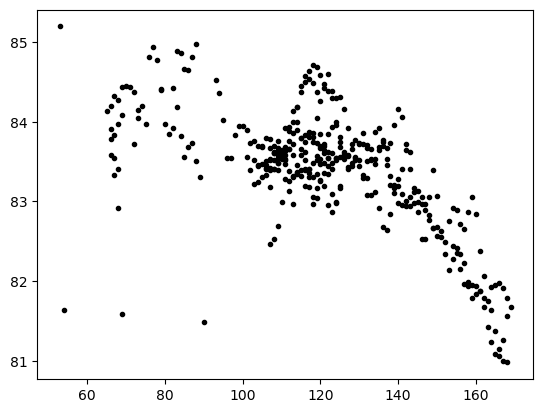

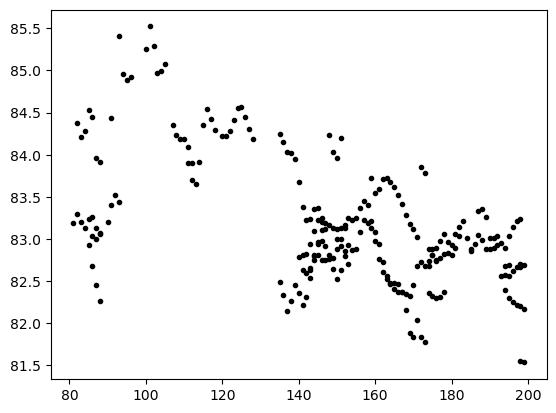

In [19]:
arr = los_vel4 + 0
for i in range(0,300):
    arr[:,i] = i
xt = arr[:16][np.isfinite(los_vel4[:16])]
vt = los_vel4[:16][np.isfinite(los_vel4[:16])]

xb = arr[16:][np.isfinite(los_vel4[16:])]
vb = los_vel4[16:][np.isfinite(los_vel4[16:])]

plt.figure()
plt.plot(xt,vt, 'k.')

plt.figure()
plt.plot(xb, vb, 'k.')

82.81630448284056
0.14489487785682773


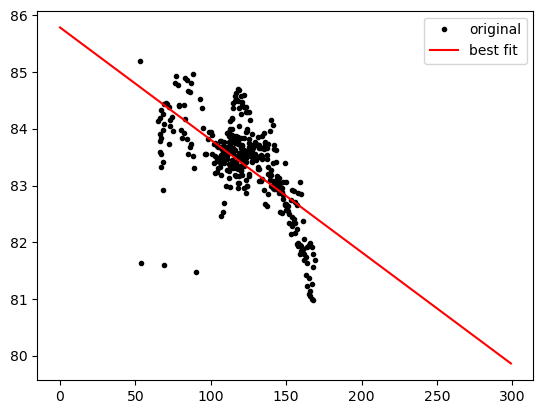

In [20]:
arr = los_vel4 + 0
for i in range(0,300):
    arr[:,i] = i
xt = arr[:16][np.isfinite(los_vel4[:16])]
vt = los_vel4[:16][np.isfinite(los_vel4[:16])]


mod = LinearModel()

pars = mod.guess(vt, x=xt)
out = mod.fit(vt, pars, x=xt)

mt = out.params['slope'].value
bt = out.params['intercept'].value
sig_mt = out.params['slope'].stderr
sig_bt = out.params['intercept'].stderr

# x_fit = np.linspace(110,219,110)
xtf = np.linspace(0,299,300)
vtf = mt * xtf + bt
vterr = np.sqrt(sig_mt**2 + sig_bt**2)

plt.figure()
plt.plot(xt, vt,'.k', label = 'original')
plt.plot(xtf, vtf, 'r', label = 'best fit')
# plt.vlines(50, ymin=77, ymax=90, color='b')
# plt.vlines(95, ymin=77, ymax=90, color='b')
# plt.vlines(140, ymin=77, ymax=90, color='y')
# plt.vlines(180, ymin=77, ymax=90, color='y')
# plt.hlines(87, xmin=0, xmax=300)
plt.legend()

print(vtf[np.where(xtf==150)][0])
print(vterr)

83.159648059716
0.17881540377636967


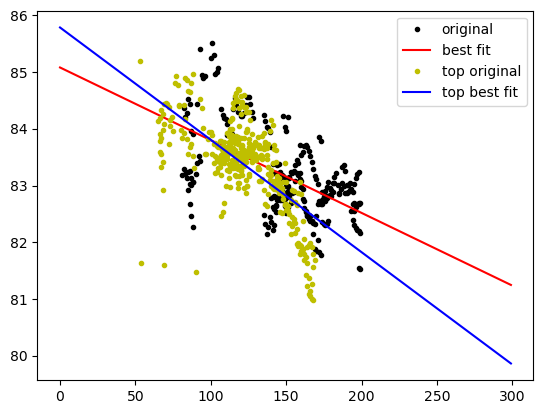

In [21]:
arr = los_vel4 + 0
for i in range(0,300):
    arr[:,i] = i
xb = arr[16:][np.isfinite(los_vel4[16:])]
vb = los_vel4[16:][np.isfinite(los_vel4[16:])]

mod = LinearModel()

pars = mod.guess(vb, x=xb)
out = mod.fit(vb, pars, x=xb)

mb = out.params['slope'].value
bb = out.params['intercept'].value
sig_mb = out.params['slope'].stderr
sig_bb = out.params['intercept'].stderr

# x_fit = np.linspace(110,219,110)
xbf = np.linspace(0,299,300)
vbf = mb * xbf + bb
vberr = np.sqrt(sig_mb**2 + sig_bb**2)

plt.figure()
plt.plot(xb, vb,'.k', label = 'original')
plt.plot(xbf, vbf, 'r', label = 'best fit')
plt.plot(xt, vt,'.y', label = 'top original')
plt.plot(xtf, vtf, 'b', label = 'top best fit')
# plt.ylim(80,90)
# plt.vlines(231, ymin=77, ymax=90, color='b')
# plt.vlines(89, ymin=77, ymax=90, color='b')
# plt.vlines(140, ymin=77, ymax=90, color='y')
# plt.vlines(180, ymin=77, ymax=90, color='y')
# plt.hlines(79, xmin=0, xmax=300)
plt.legend()

print(vbf[np.where(xbf==150)][0])
print(vberr)

In [22]:
vtf[np.where(xtf==150)][0] - vbf[np.where(xbf==150)][0]

-0.3433435768754407

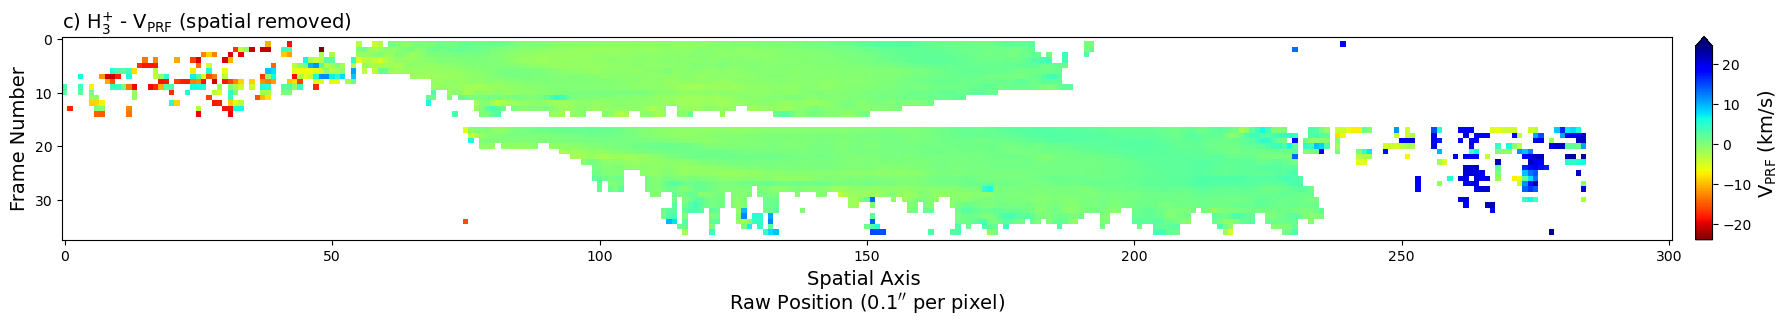

In [23]:
h3p_corrected_vel_sec1 = np.delete(h3p_corrected_vel, np.s_[16:], axis=0)
h3p_corrected_vel_sec2 = np.delete(h3p_corrected_vel, np.s_[:16], axis=0)

h3p_vprf_sec1 = h3p_corrected_vel_sec1 - vtf[np.where(xtf==150)][0]
h3p_vprf_sec2 = h3p_corrected_vel_sec2 - vbf[np.where(xbf==150)][0]

h3p_vprf = np.vstack((h3p_vprf_sec1, h3p_vprf_sec2))
# h3p_vprf[h3p_vprf > 1] = 1
# h3p_vprf[h3p_vprf < -3] = -3
h3p_vprf[0] = np.nan
h3p_vprf[15] = np.nan
h3p_vprf[16] = np.nan
h3p_vprf[-1] = np.nan
h3p_vprf[15:,:50] = np.nan


fig = plt.figure(figsize=(24,8), tight_layout=True)

fig.add_subplot(313)
plt.imshow(h3p_vprf*(-1), cmap='jet_r')
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=14)
plt.ylabel('Frame Number', fontsize=14)
plt.title('c) H$_3^{+}$ - V$_{\mathrm{PRF}}$ (spatial removed)', loc='left', fontsize=14)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='V$_{\mathrm{PRF}}$ (km/s)',size=14)

In [24]:
h3p_los_shifted_error

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [25]:
h3p_los_shifted_error_sec1 = np.delete(h3p_los_shifted_error, np.s_[16:], axis=0)
h3p_los_shifted_error_sec2 = np.delete(h3p_los_shifted_error, np.s_[:16], axis=0)

In [26]:
vterr

0.14489487785682773

In [27]:
vberr

0.17881540377636967

In [28]:
spat_err = fits.open('h3p_spat_err.fits', ignore_missing_end=True)[0].data
spat_err

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [29]:
spat_err_sec1 = np.delete(spat_err, np.s_[16:], axis=0)
spat_err_sec2 = np.delete(spat_err, np.s_[:16], axis=0)

In [30]:
h3p_tot_error_sec1 = np.sqrt((h3p_los_shifted_error_sec1)**2 + (vterr)**2 + (spat_err_sec1)**2)
h3p_tot_error_sec2 = np.sqrt((h3p_los_shifted_error_sec2)**2 + (vberr)**2 + (spat_err_sec2)**2)

h3p_tot_error = np.vstack((h3p_tot_error_sec1, h3p_tot_error_sec2))
h3p_tot_error

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

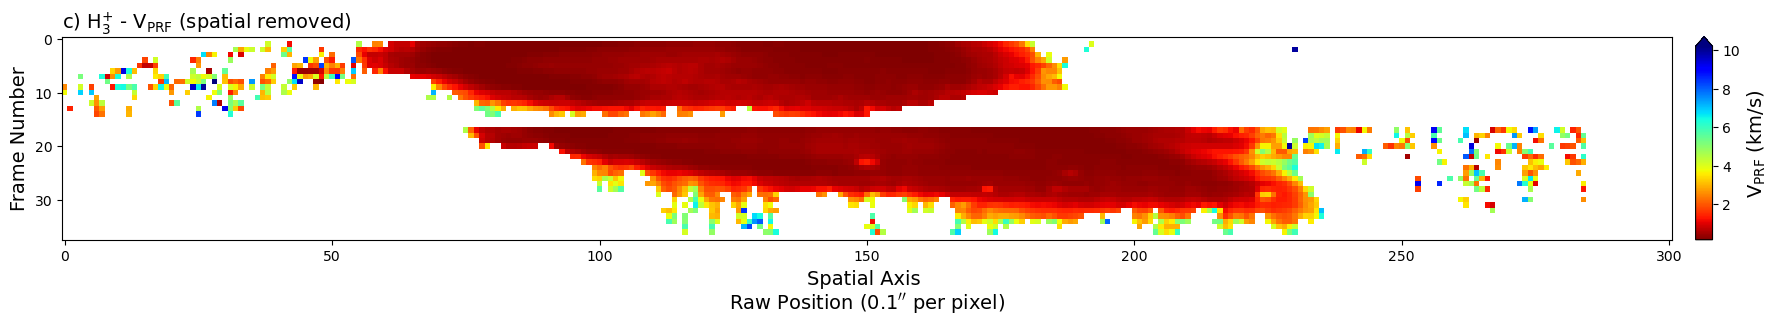

In [31]:
fig = plt.figure(figsize=(24,8), tight_layout=True)

fig.add_subplot(313)
plt.imshow(h3p_tot_error, cmap='jet_r')
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=14)
plt.ylabel('Frame Number', fontsize=14)
plt.title('c) H$_3^{+}$ - V$_{\mathrm{PRF}}$ (spatial removed)', loc='left', fontsize=14)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='V$_{\mathrm{PRF}}$ (km/s)',size=14)

In [32]:
hdu1 = fits.PrimaryHDU(h3p_vprf)
hdu1.writeto('h3p_vprf.fits', overwrite=True)

hdu2 = fits.PrimaryHDU(h3p_tot_error)
hdu2.writeto('h3p_vprf_err.fits', overwrite=True)